## Siamese Neural Networks

We are using the pretrained weights and model from [@martinpiotte](https://kaggle.com/martinpiotte). 

In [1]:
# Read the dataset description
import gzip
# Read or generate p2h, a dictionary of image name to image id (picture to hash)
import pickle
import platform
import random
# Suppress annoying stderr output when importing keras.
import sys
from lap import lapjv
from math import sqrt
# Determine the size of each image
from os.path import isfile

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image as pil_image
from imagehash import phash
from keras import backend as K
from keras import regularizers
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, \
    Lambda, MaxPooling2D, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import Sequence
from pandas import read_csv
from scipy.ndimage import affine_transform
from tqdm import tqdm_notebook as tqdm
import time

Using TensorFlow backend.


In [ ]:
TRAIN_DF = 'humpback-whale-identification/train.csv'
SUB_Df = 'humpback-whale-identification/sample_submission.csv'
TRAIN = 'humpback-whale-identification/train/'
TEST = 'humpback-whale-identification/test/'
P2H = 'metadata/p2h.pickle'
P2SIZE = 'metadata/p2size.pickle'
BB_DF = "metadata/bounding_boxes.csv"
tagged = dict([(p, w) for _, p, w in read_csv(TRAIN_DF).to_records()])
submit = [p for _, p, _ in read_csv(SUB_Df).to_records()]
join = list(tagged.keys()) + submit

In [ ]:
def expand_path(p):
    if isfile(TRAIN + p):
        return TRAIN + p
    if isfile(TEST + p):
        return TEST + p
    return p

# Duplicate image identification
This section describes the heuristic used to identify duplicate images. The fact that the training and test set have duplicate images has already been well documented. Some images are perfect binary copies, while other have been altered somewhat: contrast and brightness, size, masking the legend, etc. 

Two images are considered duplicate if they meet the following criteria:

1. Both images have the same [Perceptual Hash](http://www.phash.org/) (phash); or
1. Both images have:
    1. phash that differ by at most 6 bits, and;
    1. have the same size, and;
    1. the pixelwise mean square error between the normalized images is below a given threshold.

The *p2h* dictionary associate a unique image id (phash) for each picture. The *h2p* dictionary associate each unique image id to the prefered image to be used for this hash.

The prefered image is the one with the highest resolution, or any one if they have the same resolution.

In [ ]:
if isfile(P2SIZE):
    print("P2SIZE exists.")
    with open(P2SIZE, 'rb') as f:
        p2size = pickle.load(f)
else:
    p2size = {}
    for p in tqdm(join):
        size = pil_image.open(expand_path(p)).size
        p2size[p] = size

In [ ]:
def match(h1, h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 = pil_image.open(expand_path(p1))
            i2 = pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1 / sqrt((a1 ** 2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2 / sqrt((a2 ** 2).mean())
            a = ((a1 - a2) ** 2).mean()
            if a > 0.1: return False
    return True


if isfile(P2H):
    print("P2H exists.")
    with open(P2H, 'rb') as f:
        p2h = pickle.load(f)
else:
    # Compute phash for each image in the training and test set.
    p2h = {}
    for p in tqdm(join):
        img = pil_image.open(expand_path(p))
        h = phash(img)
        p2h[p] = h

    # Find all images associated with a given phash value.
    h2ps = {}
    for p, h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)

    # Find all distinct phash values
    hs = list(h2ps.keys())

    # If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
    h2h = {}
    for i, h1 in enumerate(tqdm(hs)):
        for h2 in hs[:i]:
            if h1 - h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                if s1 < s2: s1, s2 = s2, s1
                h2h[s1] = s2

    # Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
    for p, h in p2h.items():
        h = str(h)
        if h in h2h: h = h2h[h]
        p2h[p] = h
#     with open(P2H, 'wb') as f:
#         pickle.dump(p2h, f)
# For each image id, determine the list of pictures
h2ps = {}
for p, h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)

In [ ]:
def show_whale(imgs, per_row=2):
    n = len(imgs)
    rows = (n + per_row - 1) // per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows, cols, figsize=(24 // per_row * cols, 24 // per_row * rows))
    for ax in axes.flatten(): ax.axis('off')
    for i, (img, ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))
        

def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    return img

In [ ]:
# For each images id, select the prefered image
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0] * s[1] > best_s[0] * best_s[1]:  # Select the image with highest resolution
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h, ps in h2ps.items():
    h2p[h] = prefer(ps)
len(h2p), list(h2p.items())[:5]

In [ ]:
# Read the bounding box data from the bounding box kernel (see reference above)
p2bb = pd.read_csv(BB_DF).set_index("Image")

old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')

sys.stderr = old_stderr

img_shape = (384, 384, 1)  # The image shape used by the model
anisotropy = 2.15  # The horizontal compression ratio
crop_margin = 0.05  # The margin added around the bounding box to compensate for bounding box inaccuracy

In [ ]:
def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    Build a transformation matrix with the specified characteristics.
    """
    rotation = np.deg2rad(rotation)
    shear = np.deg2rad(shear)
    rotation_matrix = np.array(
        [[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix = np.array([[1.0 / height_zoom, 0, 0], [0, 1.0 / width_zoom, 0], [0, 0, 1]])
    shift_matrix = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

In [ ]:
def read_cropped_image(p, augment):
    """
    @param p : the name of the picture to read
    @param augment: True/False if data augmentation should be performed
    @return a numpy array with the transformed image
    """
    # If an image id was given, convert to filename
    if p in h2p:
        p = h2p[p]
    size_x, size_y = p2size[p]

    # Determine the region of the original image we want to capture based on the bounding box.
    row = p2bb.loc[p]
    x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1']
    dx = x1 - x0
    dy = y1 - y0
    x0 -= dx * crop_margin
    x1 += dx * crop_margin + 1
    y0 -= dy * crop_margin
    y1 += dy * crop_margin + 1
    if x0 < 0:
        x0 = 0
    if x1 > size_x:
        x1 = size_x
    if y0 < 0:
        y0 = 0
    if y1 > size_y:
        y1 = size_y
    dx = x1 - x0
    dy = y1 - y0
    if dx > dy * anisotropy:
        dy = 0.5 * (dx / anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx = 0.5 * (dy * anisotropy - dx)
        x0 -= dx
        x1 += dx

    # Generate the transformation matrix
    trans = np.array([[1, 0, -0.5 * img_shape[0]], [0, 1, -0.5 * img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0) / img_shape[0], 0, 0], [0, (x1 - x0) / img_shape[1], 0], [0, 0, 1]]), trans)
    if augment:
        trans = np.dot(build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.8, 1.0),
            random.uniform(0.8, 1.0),
            random.uniform(-0.05 * (y1 - y0), 0.05 * (y1 - y0)),
            random.uniform(-0.05 * (x1 - x0), 0.05 * (x1 - x0))
        ), trans)
    trans = np.dot(np.array([[1, 0, 0.5 * (y1 + y0)], [0, 1, 0.5 * (x1 + x0)], [0, 0, 1]]), trans)

    # Read the image, transform to black and white and comvert to numpy array
    img = read_raw_image(p).convert('L')
    img = img_to_array(img)

    # Apply affine transformation
    matrix = trans[:2, :2]
    offset = trans[:2, 2]
    img = img.reshape(img.shape[:-1])
    img = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant',
                           cval=np.average(img))
    img = img.reshape(img_shape)

    # Normalize to zero mean and unit variance
    img -= np.mean(img, keepdims=True)
    img /= np.std(img, keepdims=True) + K.epsilon()
    return img

def read_for_training(p):
    """
    Read and preprocess an image with data augmentation (random transform).
    """
    return read_cropped_image(p, True)


def read_for_validation(p):
    """
    Read and preprocess an image without data augmentation (use for testing).
    """
    return read_cropped_image(p, False)


p = list(tagged.keys())[312]

In [ ]:
def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y)  # Reduce the number of features to 'filter'
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y)  # Extend the feature field
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y)  # no activation # Restore the number of original features
    #y = Add()([x, y])  # Add the bypass connection
    y = Activation('relu')(y)
    return y


def build_model(lr, l2, activation='sigmoid'):
    ##############
    # BRANCH MODEL
    ##############
    regul = regularizers.l2(l2)
    optim = Adam(lr=lr)
    kwargs = {'padding': 'same', 'kernel_regularizer': regul}

    inp = Input(shape=img_shape)  # 384x384x1
    x = Conv2D(64, (9, 9), strides=2, activation='relu', **kwargs)(inp)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1, 1), activation='relu', **kwargs)(x)  # 48x48x128
    for _ in range(4):
        x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), activation='relu', **kwargs)(x)  # 24x24x256
    for _ in range(4):
        x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1, 1), activation='relu', **kwargs)(x)  # 12x12x384
    for _ in range(4):
        x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1, 1), activation='relu', **kwargs)(x)  # 6x6x512
    for _ in range(4):
        x = subblock(x, 128, **kwargs)

    x = GlobalMaxPooling2D()(x)  # 512
    branch_model = Model(inp, x)

    ############
    # HEAD MODEL
    ############
    mid = 32
    xa_inp = Input(shape=branch_model.output_shape[1:])
    xb_inp = Input(shape=branch_model.output_shape[1:])
    x1 = Lambda(lambda x: x[0] * x[1])([xa_inp, xb_inp])
    x2 = Lambda(lambda x: x[0] + x[1])([xa_inp, xb_inp])
    x3 = Lambda(lambda x: K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4 = Lambda(lambda x: K.square(x))(x3)
    x = Concatenate()([x1, x2, x3, x4])
    x = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x = Flatten(name='flatten')(x)

    # Weighted sum implemented as a Dense layer.
    x = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a = Input(shape=img_shape)
    img_b = Input(shape=img_shape)
    xa = branch_model(img_a)
    xb = branch_model(img_b)
    x = head_model([xa, xb])
    model = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model


model, branch_model, head_model = build_model(64e-5, 0)

In [ ]:
h2ws = {}
new_whale = 'new_whale'
for p, w in tagged.items():
    if w != new_whale:  # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h, ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)

# For each whale, find the unambiguous images ids.
w2hs = {}
for h, ws in h2ws.items():
    if len(ws) == 1:  # Use only unambiguous pictures
        w = ws[0]
        if w not in w2hs: w2hs[w] = []
        if h not in w2hs[w]: w2hs[w].append(h)
for w, hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)

In [ ]:
train = []  # A list of training image ids
for hs in w2hs.values():
    if len(hs) > 1:
        train += hs
random.shuffle(train)
train_set = set(train)

w2ts = {}  # Associate the image ids from train to each whale id.
for w, hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts:
                w2ts[w] = []
            if h not in w2ts[w]:
                w2ts[w].append(h)
for w, ts in w2ts.items():
    w2ts[w] = np.array(ts)

t2i = {}  # The position in train of each training image id
for i, t in enumerate(train):
    t2i[t] = i

In [ ]:
class TrainingData(Sequence):
    def __init__(self, score, steps=1000, batch_size=32):
        """
        @param score the cost matrix for the picture matching
        @param steps the number of epoch we are planning with this score matrix
        """
        super(TrainingData, self).__init__()
        self.score = -score  # Maximizing the score is the same as minimuzing -score.
        self.steps = steps
        self.batch_size = batch_size
        for ts in w2ts.values():
            idxs = [t2i[t] for t in ts]
            for i in idxs:
                for j in idxs:
                    self.score[
                        i, j] = 10000.0  # Set a large value for matching whales -- eliminates this potential pairing
        self.on_epoch_end()

    def __getitem__(self, index):
        start = self.batch_size * index
        end = min(start + self.batch_size, len(self.match) + len(self.unmatch))
        size = end - start
        assert size > 0
        a = np.zeros((size,) + img_shape, dtype=K.floatx())
        b = np.zeros((size,) + img_shape, dtype=K.floatx())
        c = np.zeros((size, 1), dtype=K.floatx())
        j = start // 2
        for i in range(0, size, 2):
            a[i, :, :, :] = read_for_training(self.match[j][0])
            b[i, :, :, :] = read_for_training(self.match[j][1])
            c[i, 0] = 1  # This is a match
            a[i + 1, :, :, :] = read_for_training(self.unmatch[j][0])
            b[i + 1, :, :, :] = read_for_training(self.unmatch[j][1])
            c[i + 1, 0] = 0  # Different whales
            j += 1
        return [a, b], c

    def on_epoch_end(self):
        if self.steps <= 0: return  # Skip this on the last epoch.
        self.steps -= 1
        self.match = []
        self.unmatch = []
        _, _, x = lapjv(self.score)  # Solve the linear assignment problem
        y = np.arange(len(x), dtype=np.int32)

        # Compute a derangement for matching whales
        for ts in w2ts.values():
            d = ts.copy()
            while True:
                random.shuffle(d)
                if not np.any(ts == d): break
            for ab in zip(ts, d): self.match.append(ab)

        # Construct unmatched whale pairs from the LAP solution.
        for i, j in zip(x, y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i, j)
            assert i != j
            self.unmatch.append((train[i], train[j]))

        # Force a different choice for an eventual next epoch.
        self.score[x, y] = 10000.0
        self.score[y, x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
        # print(len(self.match), len(train), len(self.unmatch), len(train))
        assert len(self.match) == len(train) and len(self.unmatch) == len(train)

    def __len__(self):
        return (len(self.match) + len(self.unmatch) + self.batch_size - 1) // self.batch_size


# Test on a batch of 32 with random costs.
score = np.random.random_sample(size=(len(train), len(train)))
data = TrainingData(score)
(a, b), c = data[0]

In [ ]:
# A Keras generator to evaluate only the BRANCH MODEL
class FeatureGen(Sequence):
    def __init__(self, data, batch_size=64, verbose=1):
        super(FeatureGen, self).__init__()
        self.data = data
        self.batch_size = batch_size
        self.verbose = verbose
        if self.verbose > 0: self.progress = tqdm(total=len(self), desc='Features')

    def __getitem__(self, index):
        start = self.batch_size * index
        size = min(len(self.data) - start, self.batch_size)
        a = np.zeros((size,) + img_shape, dtype=K.floatx())
        for i in range(size): a[i, :, :, :] = read_for_validation(self.data[start + i])
        if self.verbose > 0:
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return a

    def __len__(self):
        return (len(self.data) + self.batch_size - 1) // self.batch_size


class ScoreGen(Sequence):
    def __init__(self, x, y=None, batch_size=2048, verbose=1):
        super(ScoreGen, self).__init__()
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.verbose = verbose
        if y is None:
            self.y = self.x
            self.ix, self.iy = np.triu_indices(x.shape[0], 1)
        else:
            self.iy, self.ix = np.indices((y.shape[0], x.shape[0]))
            self.ix = self.ix.reshape((self.ix.size,))
            self.iy = self.iy.reshape((self.iy.size,))
        self.subbatch = (len(self.x) + self.batch_size - 1) // self.batch_size
        if self.verbose > 0:
            self.progress = tqdm(total=len(self), desc='Scores')

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, len(self.ix))
        a = self.y[self.iy[start:end], :]
        b = self.x[self.ix[start:end], :]
        if self.verbose > 0:
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return [a, b]

    def __len__(self):
        return (len(self.ix) + self.batch_size - 1) // self.batch_size


In [ ]:
def set_lr(model, lr):
    K.set_value(model.optimizer.lr, float(lr))


def get_lr(model):
    return K.get_value(model.optimizer.lr)


def score_reshape(score, x, y=None):
    """
    Tranformed the packed matrix 'score' into a square matrix.
    @param score the packed matrix
    @param x the first image feature tensor
    @param y the second image feature tensor if different from x
    @result the square matrix
    """
    if y is None:
        # When y is None, score is a packed upper triangular matrix.
        # Unpack, and transpose to form the symmetrical lower triangular matrix.
        m = np.zeros((x.shape[0], x.shape[0]), dtype=K.floatx())
        m[np.triu_indices(x.shape[0], 1)] = score.squeeze()
        m += m.transpose()
    else:
        m = np.zeros((y.shape[0], x.shape[0]), dtype=K.floatx())
        iy, ix = np.indices((y.shape[0], x.shape[0]))
        ix = ix.reshape((ix.size,))
        iy = iy.reshape((iy.size,))
        m[iy, ix] = score.squeeze()
    return m


def compute_score(verbose=1):
    """
    Compute the score matrix by scoring every pictures from the training set against every other picture O(n^2).
    """
    features = branch_model.predict_generator(FeatureGen(train, verbose=verbose), max_queue_size=12, workers=6,
                                              verbose=0)
    score = head_model.predict_generator(ScoreGen(features, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score = score_reshape(score, features)
    return features, score


def make_steps(step, ampl):
    """
    Perform training epochs
    @param step Number of epochs to perform
    @param ampl the K, the randomized component of the score matrix.
    """
    global w2ts, t2i, steps, features, score, histories

    # shuffle the training pictures
    random.shuffle(train)

    # Map whale id to the list of associated training picture hash value
    w2ts = {}
    for w, hs in w2hs.items():
        for h in hs:
            if h in train_set:
                if w not in w2ts: w2ts[w] = []
                if h not in w2ts[w]: w2ts[w].append(h)
    for w, ts in w2ts.items(): w2ts[w] = np.array(ts)

    # Map training picture hash value to index in 'train' array    
    t2i = {}
    for i, t in enumerate(train): t2i[t] = i

    # Compute the match score for each picture pair
    features, score = compute_score()

    # Train the model for 'step' epochs
    history = model.fit_generator(
        TrainingData(score + ampl * np.random.random_sample(size=score.shape), steps=step, batch_size=32),
        initial_epoch=steps, epochs=steps + step, max_queue_size=12, workers=6, verbose=1).history
    steps += step

    # Collect history data
    history['epochs'] = steps
    history['ms'] = np.mean(score)
    history['lr'] = get_lr(model)
    print(history['epochs'], history['lr'], history['ms'])
    histories.append(history)

In [ ]:
import pickle
weights_list = []
set_lr(model, 64e-5)
steps = 0

for layer in model.layers:
    weights = layer.get_weights()
    weights_list.append(weights)

histories = []
amplitudes = [100, 10, 1, 0.5, 0.25]
for i in range (len(amplitudes)):
    make_steps(1, amplitudes[i])
    print("step = ", steps)
    print('amplitude  = ', amplitudes[i])
    print ("new histories dict value = ", histories[0])
    print ("current histories dict = ", histories)
#     layer_nbr = 0
#     for layer in model.layers:
#         layer_nbr = layer_nbr +1
#         weights = layer.get_weights()
#         print("layer =", layer_nbr)
#         print ("weights =", weights)
#         weights_list.append(weights)
#     print (weights_list)
    with open('{}_{}'.format('train_dict',i), 'wb') as file_pi:
        pickle.dump(histories, file_pi)

with open('train_dict_all', 'wb') as file_pi:
    pickle.dump(histories, file_pi)
    
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
pickle_in = open("train_dict","rb")
train_dict = pickle.load(pickle_in)
print(train_dict)

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
branch_model_json = branch_model.to_json()
with open("branch_model.json", "w") as json_file:
    json_file.write(branch_model_json)
    
head_model_json = head_model.to_json()
with open("head_model.json", "w") as json_file:
    json_file.write(head_model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

model.save_weights("branch_model.h5")
print("Saved branch_model to disk")

model.save_weights("head_model.h5")
print("Saved head_model to disk")

In [ ]:
w = w.flatten().tolist()
w = sorted(w)
fig, axes = plt.subplots(1,1)
axes.bar(range(len(w)), w)
plt.show()

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(w2ts, t2i.items()[1], verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
histories = []
steps = 0

if isfile('piotte/mpiotte-standard.model'):
    tmp = keras.models.load_model('piotte/mpiotte-standard.model')
    model.set_weights(tmp.get_weights())
else:
    print("model not available")
    # epoch -> 10
    make_steps(2, 1000)
    ampl = 100.0
    for _ in range(2):
        print('noise ampl.  = ', ampl)
        make_steps(5, ampl)
        ampl = max(1.0, 100 ** -0.1 * ampl)
    # epoch -> 150
    for _ in range(18): make_steps(5, 1.0)
    # epoch -> 200
    set_lr(model, 16e-5)
    for _ in range(10): make_steps(5, 0.5)
    # epoch -> 240
    set_lr(model, 4e-5)
    for _ in range(8): make_steps(5, 0.25)
    # epoch -> 250
    set_lr(model, 1e-5)
    for _ in range(2): make_steps(5, 0.25)
    # epoch -> 300
    weights = model.get_weights()
    model, branch_model, head_model = build_model(64e-5, 0.0002)
    model.set_weights(weights)
    for _ in range(10): make_steps(5, 1.0)
    # epoch -> 350
    set_lr(model, 16e-5)
    for _ in range(10): make_steps(5, 0.5)
    # epoch -> 390
    set_lr(model, 4e-5)
    for _ in range(8): make_steps(5, 0.25)
    # epoch -> 400
    set_lr(model, 1e-5)
    for _ in range(2): make_steps(5, 0.25)
    model.save('standard.model')

In [ ]:
print(histories)

In [ ]:
model.summary()

## Generate Kaggle submission

In [ ]:
def prepare_submission(threshold, filename):
    """
    Generate a Kaggle submission file.
    @param threshold the score given to 'new_whale'
    @param filename the submission file name
    """
    vtop = 0
    vhigh = 0
    pos = [0, 0, 0, 0, 0, 0]
    with open(filename, 'wt', newline='\n') as f:
        f.write('Image,Id\n')
        for i, p in enumerate(tqdm(submit)):
            t = []
            s = set()
            a = score[i, :]
            for j in list(reversed(np.argsort(a))):
                h = known[j]
                if a[j] < threshold and new_whale not in s:
                    pos[len(t)] += 1
                    s.add(new_whale)
                    t.append(new_whale)
                    if len(t) == 5: break;
                for w in h2ws[h]:
                    assert w != new_whale
                    if w not in s:
                        if a[j] > 1.0:
                            vtop += 1
                        elif a[j] >= threshold:
                            vhigh += 1
                        s.add(w)
                        t.append(w)
                        if len(t) == 5: break;
                if len(t) == 5: break;
            if new_whale not in s: pos[5] += 1
            assert len(t) == 5 and len(s) == 5
            f.write(p + ',' + ' '.join(t[:5]) + '\n')
    return vtop, vhigh, pos

In [ ]:
# Find elements from training sets not 'new_whale'
tic = time.time()
h2ws = {}
for p, w in tagged.items():
    if w != new_whale:  # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
known = sorted(list(h2ws.keys()))

# Dictionary of picture indices
h2i = {}
for i, h in enumerate(known): h2i[h] = i

# Evaluate the model.
fknown = branch_model.predict_generator(FeatureGen(known), max_queue_size=20, workers=10, verbose=0)
fsubmit = branch_model.predict_generator(FeatureGen(submit), max_queue_size=20, workers=10, verbose=0)
score = head_model.predict_generator(ScoreGen(fknown, fsubmit), max_queue_size=20, workers=10, verbose=0)
# score = score_reshape(score, fknown, fsubmit)

# Generate the subsmission file.
prepare_submission(0.99, 'submission.csv')
toc = time.time()
print("Submission time: ", (toc - tic) / 60.)

### Show filters from https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html


In [2]:
# load json and create model
from keras.models import model_from_json
json_file = open('branch_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
w = loaded_model.layers[1].get_weights()


In [3]:
import cv2
input_img = cv2.imread('00caa5c60.jpg')
# cv2.imshow('whale',input_img)

In [15]:
from keras import applications

# build the VGG16 network
model = loaded_model
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [16]:
from keras import backend as K

layer_name = 'conv2d_4'
filter_index = 5  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:,:, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

ValueError: Tried to convert 'x' to a tensor and failed. Error: None values not supported.

In [ ]:
import numpy as np

# we start from a gray image with some noise
input_img_data = np.random.random((1, 3, img_width, img_height)) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [ ]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)
imsave('%s_filter_%d.png' % (layer_name, filter_index), img)

## Martin Piotte method to print weights

In [17]:
# load json and create branch model
from keras.models import model_from_json
json_file = open('branch_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
branch_model = model_from_json(loaded_model_json)

In [19]:
def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

In [22]:
img_shape    = (384,384,1)

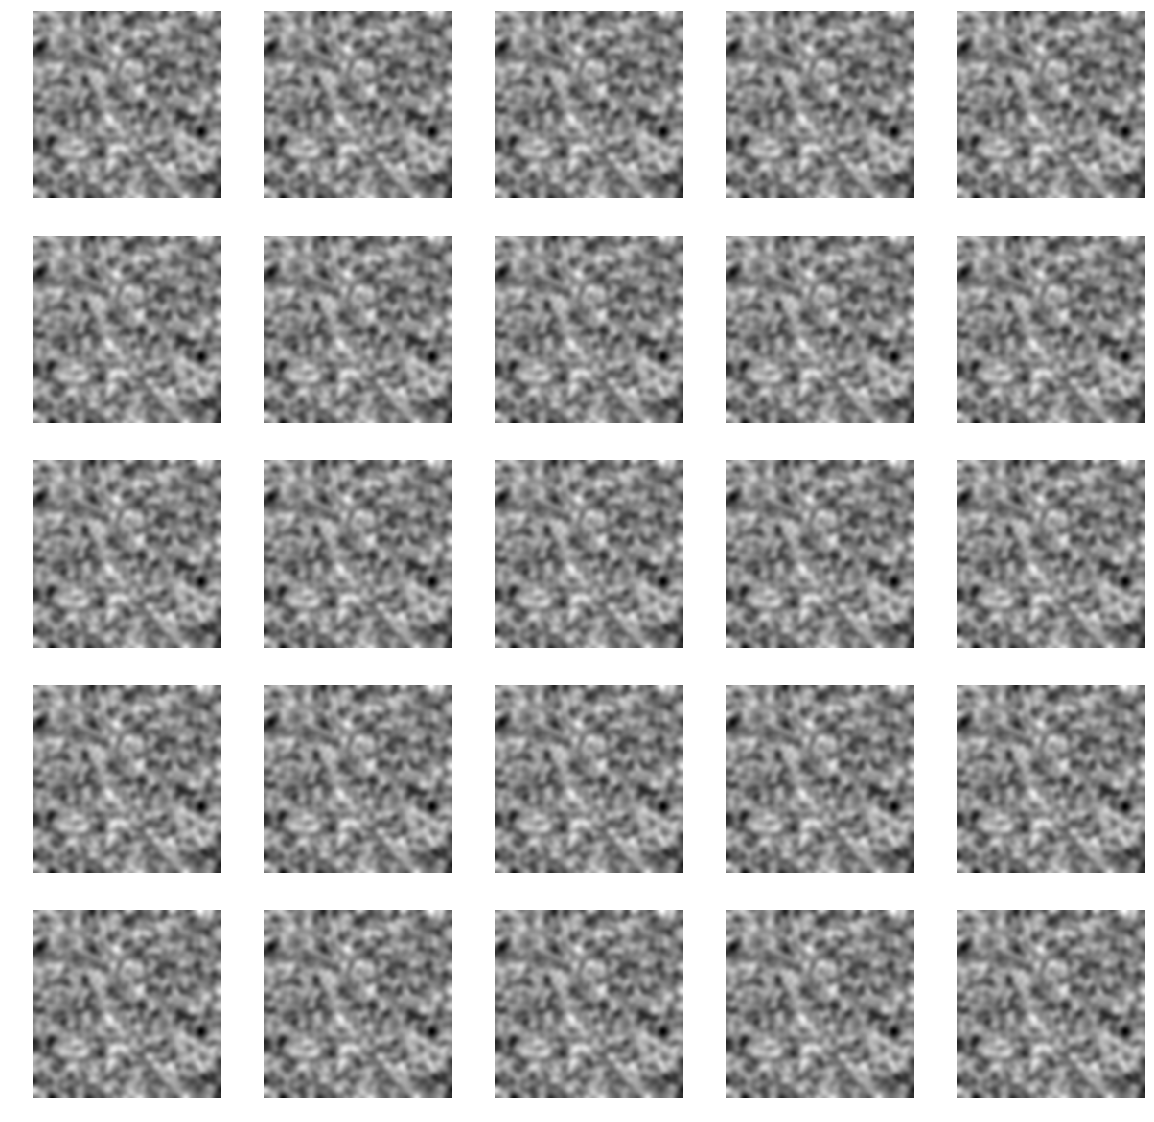

In [24]:
from scipy.ndimage import gaussian_filter
from keras.preprocessing.image import img_to_array,array_to_img

def show_filter(filter, blur):
    np.random.seed(1)
    noise   = 0.1 # Initial noise
    step    = 1 # Gradient step
    
    # Construct the function
    inp     = branch_model.layers[0].get_input_at(0)
    loss    = K.mean(branch_model.layers[-3].output[0,2:4,2:4,filter]) # Stimulate the 4 central cells
    grads   = K.gradients(loss, inp)[0]
    grads  /= K.sqrt(K.mean(K.square(grads))) + K.epsilon()
    iterate = K.function([inp],[grads])
    img     = (np.random.random(img_shape) -0.5)*noise
    img     = np.expand_dims(img, 0)
    # Use gradient descent to form image
    for i in range(200):
        grads_value = iterate([img])[0]
        # Blurring a little creates nicer images by reducing reconstruction noise
        img = gaussian_filter(img + grads_value*step, sigma=blur)

    # Clip the image to improve contrast
    avg  = np.mean(img)
    std  = sqrt(np.mean((img - avg)**2))
    low  = avg - 5*std
    high = avg + 5*std
    return array_to_img(np.minimum(high, np.maximum(low, img))[0])

# Show the first 25 features (of 512)
show_whale([show_filter(i, 0.5) for i in tqdm(range(5))], per_row=5)